In [ ]:
import math
import random
import threading
from functools import partial
from pathlib import Path

import numpy as np
import pandas as pd
import rasterio as rio
import segmentation_models_pytorch as smp
import timm
import torch
import torch.nn.functional as F
from fastai.vision.all import (
    DataBlock,
    FuncSplitter,
    GradientAccumulation,
    IntToFloatTensor,
    JaccardCoeff,
    Learner,
    SaveModelCallback,
    ShowGraphCallback,
    TensorImage,
    TensorMask,
    TransformBlock,
    create_unet_model,
)
from fastprogress import progress_bar
from rasterio.windows import Window
from safetensors.torch import save_file
from torch.nn import CrossEntropyLoss

In [2]:
from augs import (
    BatchFlip,
    # BatchResample,
    BatchRot90,
    BatchTear,
    ClipHighAndLow,
    DynamicZScoreNormalize,
    # QuantizeBatchSize,
    # RandomClipLargeImages,
    RandomRectangle,
    RandomSharpenBlur,
    SceneEdge,
)
from helpers import plot_batch, print_system_info, show_histo
from utils import IgnoreIndexMetric, distance_transform_torch

print_system_info()

System Information
-----------------------------------
PyTorch Version : 2.9.1+cu128
CUDA Available  : Yes
CUDA Version    : 12.8
Python Version  : 3.13.7
Fastai Version  : 2.8.6
Default Device  : cuda:0
Device Name     : NVIDIA GeForce RTX 4090
-----------------------------------


In [3]:
#  smp has less dependencies and lower vram usage than fastai, so use smp if possible

# model_provider = "smp"
model_provider = "fastai"  # used for OWM v1

In [4]:
# These are all reasonable model backbones for the task

# model_type = "regnety_006.pycls_in1k"
# model_type = "regnety_004.pycls_in1k" #
# model_type = "regnety_002.pycls_in1k"

# model_type = "edgenext_small.in1k"
model_type = "edgenext_x_small.in1k"
# model_type = "edgenext_xx_small.in1k"

# model_type = "convnextv2_nano.fcmae_ft_in1k"
# model_type = "convnextv2_pico.fcmae_ft_in1k"
# model_type = "convnextv2_femto.fcmae_ft_in1k"
# model_type = "convnextv2_atto.fcmae_ft_in1k"

# model_type = "convnextv2_nano.fcmae_ft_in1k"
# model_type = "convnextv2_tiny.fcmae_ft_in22k_in1k_384"
# model_type = "convnextv2_base.fcmae_ft_in22k_in1k_384"  # Used for OWM v1

In [5]:
flair_training_data_dir = Path(
    "/media/nick/4TB Working 6/Datasets/FLAIR_retrain/train/FLAIR patches"
)
s1s2_training_data_dir = Path("/media/nick/4TB Working 6/Datasets/S1S2-Water/train")

flair_water_only_csv_path = (
    flair_training_data_dir.parent / "FLAIR_patches_with_water.csv"
)


In [6]:
assert flair_training_data_dir.exists()
assert s1s2_training_data_dir.exists()
assert flair_water_only_csv_path.exists()

In [7]:
sources = [flair_training_data_dir, s1s2_training_data_dir]
sources

[Path('/media/nick/4TB Working 6/Datasets/FLAIR_retrain/train/FLAIR patches'),
 Path('/media/nick/4TB Working 6/Datasets/S1S2-Water/train')]

In [8]:
model_base_name = "2.0.9"

In [9]:
max_clip_image_size = 200
min_clip_image_size = 100

In [10]:
only_water_flair = True

labels_folder_name = "labels"

batch_size = 64
GA_batch_size = 500

epoch_count = 15

learning_rate = 0.0001

class_loss_weights = [1, 2]  # the first weight is for the background class

original_image_size = 512

bf16 = True

class_count = 2

validation_sample_frac = (
    0.1  # the s1s2 validation set is large so we only use a small fraction of it
)
# training_sample_frac = 0.1
training_sample_frac = 1.0

band_labels = ["Red", "Green", "Blue", "NIR"]

num_workers = 16

ignore_index = 99


In [11]:
name_addition = "_S1S2"
name_addition += "_L2A"

name_addition += "_flair"
if only_water_flair:
    name_addition += "_only_water"


model_full_name = f"{model_base_name}{name_addition}_{model_type.split('.')[0]}"
model_full_name

'2.0.9_S1S2_L2A_flair_only_water_edgenext_x_small'

In [12]:
s1s2_limited_band_read_list = [3, 2, 1, 4]  # Red, Green, Blue, NIR,
flair_limited_band_read_list = [1, 2, 3, 4]  # Red, Green, Blue, NIR

In [13]:
if only_water_flair:
    flair_water_df = pd.read_csv(flair_water_only_csv_path)
    water_flair_imgs = flair_water_df["image_path"].values
    water_flair_imgs = [Path(img) for img in water_flair_imgs]
    print(len(water_flair_imgs))
    water_flair_imgs = set(water_flair_imgs)

16884


In [14]:
def get_image_files_custom(sources):
    all_train_images = []
    all_val_images = []

    for source in sources:
        images_dir = source / "images"
        assert images_dir.exists(), f"Images dir {images_dir} does not exist"

        if source == s1s2_training_data_dir:
            train_images = list(images_dir.glob("*train*.tif"))
            val_images = list(images_dir.glob("*val*.tif"))
            original_val_count = len(val_images)
            print(f"Found {original_val_count} S1S2 validation images")
            val_images = random.sample(
                val_images, int(original_val_count * validation_sample_frac)
            )
            print(f"Using {len(val_images)} S1S2 validation images")

        elif source == flair_training_data_dir:
            val_images = []
            if only_water_flair:
                train_images = list(water_flair_imgs)
            else:
                train_images = list(images_dir.glob("*train*.tif"))

        else:
            raise ValueError(f"Unknown source {source}")

        print(f"Found {len(train_images)} training images from {source}")
        print(f"Found {len(val_images)} validation images from {source}")

        all_train_images += train_images
        all_val_images += val_images
    if training_sample_frac < 1:
        print(f"But only using {training_sample_frac} of them")
        # take random sample of the data
        all_train_images = random.sample(
            all_train_images, int(len(all_train_images) * training_sample_frac)
        )

    print(f"Total training images: {len(all_train_images)}")
    print(f"Total validation images: {len(all_val_images)}")
    return all_train_images + all_val_images


In [15]:
def label_func(file_path):
    file_name = file_path.name
    normalised_name = file_name.replace("_L2A", "")
    label_path = file_path.parent.parent / "labels" / normalised_name

    return label_path


def is_valid_file(x):
    if "val" in x.name:
        return True
    return False

In [16]:
# check the image getter works and that the label files exist
train_and_val_images = get_image_files_custom(sources)
for image in progress_bar(train_and_val_images):
    label_path = label_func(image)
    assert label_path.exists(), f"{label_path} does not exist from image {image}"
len(train_and_val_images)

Found 16884 training images from /media/nick/4TB Working 6/Datasets/FLAIR_retrain/train/FLAIR patches
Found 0 validation images from /media/nick/4TB Working 6/Datasets/FLAIR_retrain/train/FLAIR patches
Found 21632 S1S2 validation images
Using 2163 S1S2 validation images
Found 44616 training images from /media/nick/4TB Working 6/Datasets/S1S2-Water/train
Found 2163 validation images from /media/nick/4TB Working 6/Datasets/S1S2-Water/train
Total training images: 61500
Total validation images: 2163


63663

In [17]:
def select_scale_factor(
    min_scale: float,
    max_scale: float,
    plateau_min: float | None = None,
    plateau_max: float | None = None,
) -> float:
    """Sample from plateau distribution: fade-in, plateau, fade-out."""
    if plateau_min is None:
        plateau_min = min_scale
    if plateau_max is None:
        plateau_max = max_scale

    # Calculate ranges and areas
    lower_range = plateau_min - min_scale
    plateau_range = plateau_max - plateau_min
    upper_range = max_scale - plateau_max

    lower_area = lower_range / 2
    plateau_area = plateau_range
    upper_area = upper_range / 2

    total_area = lower_area + plateau_area + upper_area

    # Sample zone
    rand = random.random() * total_area

    if rand < lower_area:
        # Lower triangle
        u = random.random()
        return min_scale + lower_range * np.sqrt(u)
    elif rand < lower_area + plateau_area:
        # Plateau
        return random.uniform(plateau_min, plateau_max)
    else:
        # Upper triangle
        u = random.random()
        return max_scale - upper_range * np.sqrt(u)


In [18]:
def downsample_multiclass_mask(
    mask: torch.Tensor, target_size: int, water_class: int = 1, void_class: int = 99
) -> torch.Tensor:
    """Downsample preserving water pixels using torch max pooling."""

    # If already at target size, return as-is
    if mask.shape[0] == target_size:
        return mask

    # Add batch and channel dimensions
    mask_tensor = mask.float().unsqueeze(0).unsqueeze(0)

    # Create binary masks for priority classes
    water_mask = (mask_tensor == water_class).float()
    void_mask = (mask_tensor == void_class).float()

    # Use interpolate with max pooling mode for water
    # For max pooling behaviour, we need to use a workaround
    scale_factor = target_size / mask.shape[0]

    # Downsample water with max pooling to preserve small objects
    if scale_factor < 1:
        kernel_size = int(1 / scale_factor)
        stride = kernel_size

        # Calculate output size after pooling
        pooled_size = (mask.shape[0] - kernel_size) // stride + 1

        water_pooled = F.max_pool2d(water_mask, kernel_size=kernel_size, stride=stride)

        # Then resize to exact target size if needed
        if pooled_size != target_size:
            water_downsampled = (
                F.interpolate(
                    water_pooled, size=(target_size, target_size), mode="nearest"
                ).squeeze()
                > 0.5
            )
        else:
            water_downsampled = water_pooled.squeeze() > 0.5
    else:
        # Upsampling case
        water_downsampled = (
            F.interpolate(
                water_mask, size=(target_size, target_size), mode="nearest"
            ).squeeze()
            > 0.5
        )

    # Nearest neighbour for void
    void_downsampled = (
        F.interpolate(
            void_mask, size=(target_size, target_size), mode="nearest"
        ).squeeze()
        > 0.5
    )

    # Start with land everywhere (class 0)
    result = torch.zeros((target_size, target_size), dtype=torch.long)

    # Apply priority: water overwrites land, void stays as void
    result[void_downsampled] = void_class
    result[water_downsampled] = water_class

    return result.to(dtype=mask.dtype)


In [19]:
# This logic opens images and masks using a shared random crop and scale so that
# both remain aligned.
#
# A random scale factor is first selected, followed by a random spatial crop.
# The cropped region is then resampled to a target size, which effectively
# performs random resizing and random cropping in a single step.
#
# Performing these operations during I/O reduces the need for expensive
# post-load augmentations and improves data loading throughput. It also exposes
# the model to a wide range of apparent spatial resolutions, improving
# robustness to scale variation.
#
# If a scaled crop is smaller than the requested crop size, it is placed at a
# random location within the output patch. Any surrounding pixels are padded
# using per-channel mean values for imagery and with the ignore index for masks.

_crop_state = threading.local()


def open_img(
    img_path: Path,
    crop_size: int = 200,
    min_scale=0.01,
    max_scale=1.111,
    plateau_min=0.33,
    plateau_max=1.0,
):
    if img_path.parents[1] == flair_training_data_dir:
        limited_band_read_list = flair_limited_band_read_list
    elif img_path.parents[1] == s1s2_training_data_dir:
        limited_band_read_list = s1s2_limited_band_read_list
    else:
        raise ValueError("Unknown training data dir")

    if is_valid_file(img_path):
        window_size = original_image_size
        after_scale_size = original_image_size
        _crop_state.val_image = True

    else:
        image_scale = select_scale_factor(
            min_scale=min_scale,
            max_scale=max_scale,
            plateau_min=plateau_min,
            plateau_max=plateau_max,
        )

        window_size = math.ceil(min(crop_size / image_scale, original_image_size))

        after_scale_size = math.ceil(min(window_size * image_scale, crop_size))
        _crop_state.val_image = False

    with rio.open(img_path) as src:
        h, w = src.height, src.width

        # Generate and store crop params
        x_off = random.randint(0, max(0, w - window_size))
        y_off = random.randint(0, max(0, h - window_size))

        # Store for mask loader to use
        _crop_state.window = Window(x_off, y_off, window_size, window_size)
        _crop_state.after_scale_size = after_scale_size
        _crop_state.crop_size = crop_size

        bands = src.read(
            limited_band_read_list,
            window=_crop_state.window,
            out_shape=(after_scale_size, after_scale_size),
            resampling=rio.enums.Resampling.average,
        ).astype(np.float32)

    if after_scale_size < crop_size:
        start_left = random.randint(0, max(0, crop_size - after_scale_size))
        start_top = random.randint(0, max(0, crop_size - after_scale_size))
        _crop_state.start_left = start_left
        _crop_state.start_top = start_top
        channel_means = np.mean(bands, axis=(1, 2), keepdims=True)
        padded_bands = np.broadcast_to(
            channel_means,
            (bands.shape[0], crop_size, crop_size),
        ).astype(np.float32)

        padded_bands[
            :,
            start_top : start_top + after_scale_size,
            start_left : start_left + after_scale_size,
        ] = bands
        bands = padded_bands

    return TensorImage(torch.from_numpy(bands))


def open_mask(mask_path: Path):
    with rio.open(mask_path) as src:
        mask = src.read(
            1,
            window=_crop_state.window,
        )
    tensor_mask = torch.from_numpy(mask)

    if not _crop_state.val_image:
        # if not a validation image then downsample while preserving water pixels
        tensor_mask = downsample_multiclass_mask(
            tensor_mask, _crop_state.after_scale_size
        )

    if _crop_state.after_scale_size < _crop_state.crop_size:
        padded_mask = torch.full(
            (_crop_state.crop_size, _crop_state.crop_size),
            fill_value=ignore_index,
            dtype=tensor_mask.dtype,
        )
        padded_mask[
            _crop_state.start_top : _crop_state.start_top
            + _crop_state.after_scale_size,
            _crop_state.start_left : _crop_state.start_left
            + _crop_state.after_scale_size,
        ] = tensor_mask
        tensor_mask = padded_mask

    return TensorMask(tensor_mask)


In [20]:
open_img(train_and_val_images[0], crop_size=max_clip_image_size).shape

torch.Size([4, 200, 200])

In [21]:
open_img_partial = partial(
    open_img,
    crop_size=max_clip_image_size,
    min_scale=0.2,
    max_scale=1.111,
    plateau_min=0.1,
    plateau_max=0.3,
)

In [22]:
blocks = [
    TransformBlock([open_img_partial]),
    TransformBlock([open_mask]),
]


In [23]:
batch_augs = [
    IntToFloatTensor(1, 1),
    BatchFlip(),
    BatchRot90(),
    DynamicZScoreNormalize(),
    RandomRectangle(p=0.05, sh=0.1),
    SceneEdge(p=0.05),
    BatchTear(p=0.05),
    RandomSharpenBlur(min_factor=0.8, max_factor=1.2, per_sample_probability=0.1),
    ClipHighAndLow(),
]

In [24]:
dblock = DataBlock(
    blocks=blocks,
    get_items=get_image_files_custom,
    get_y=label_func,
    splitter=FuncSplitter(lambda x: is_valid_file(x)),
    batch_tfms=batch_augs,
)

In [25]:
dl = dblock.dataloaders(
    size=original_image_size,
    source=sources,
    bs=batch_size,
    num_workers=num_workers,
    pin_memory=True,
    prefetch_factor=2,
    persistent_workers=True,
)

Found 16884 training images from /media/nick/4TB Working 6/Datasets/FLAIR_retrain/train/FLAIR patches
Found 0 validation images from /media/nick/4TB Working 6/Datasets/FLAIR_retrain/train/FLAIR patches
Found 21632 S1S2 validation images
Using 2163 S1S2 validation images
Found 44616 training images from /media/nick/4TB Working 6/Datasets/S1S2-Water/train
Found 2163 validation images from /media/nick/4TB Working 6/Datasets/S1S2-Water/train
Total training images: 61500
Total validation images: 2163


In [26]:
dl.valid = dl.valid.new(bs=20)


In [27]:
for name in ["train", "valid"]:
    xb, yb = getattr(dl, name).one_batch()

    def describe(x):
        return f"shape={tuple(x.shape)}, dtype={x.dtype}, type={type(x).__name__}"

    print(f"\n{name.upper()} DATASET")
    print(f"  images: {describe(xb)}")
    print(f"  labels: {describe(yb)}")



TRAIN DATASET
  images: shape=(64, 4, 200, 200), dtype=torch.float32, type=TensorImage
  labels: shape=(64, 200, 200), dtype=torch.int64, type=TensorMask

VALID DATASET
  images: shape=(20, 4, 512, 512), dtype=torch.float32, type=TensorImage
  labels: shape=(20, 512, 512), dtype=torch.int64, type=TensorMask


In [28]:
train_batch = dl.one_batch()

num_input_channels = train_batch[0].shape[1]
num_input_channels


4

Image tensor shape: torch.Size([64, 4, 200, 200])
Label shape: torch.Size([64, 200, 200])


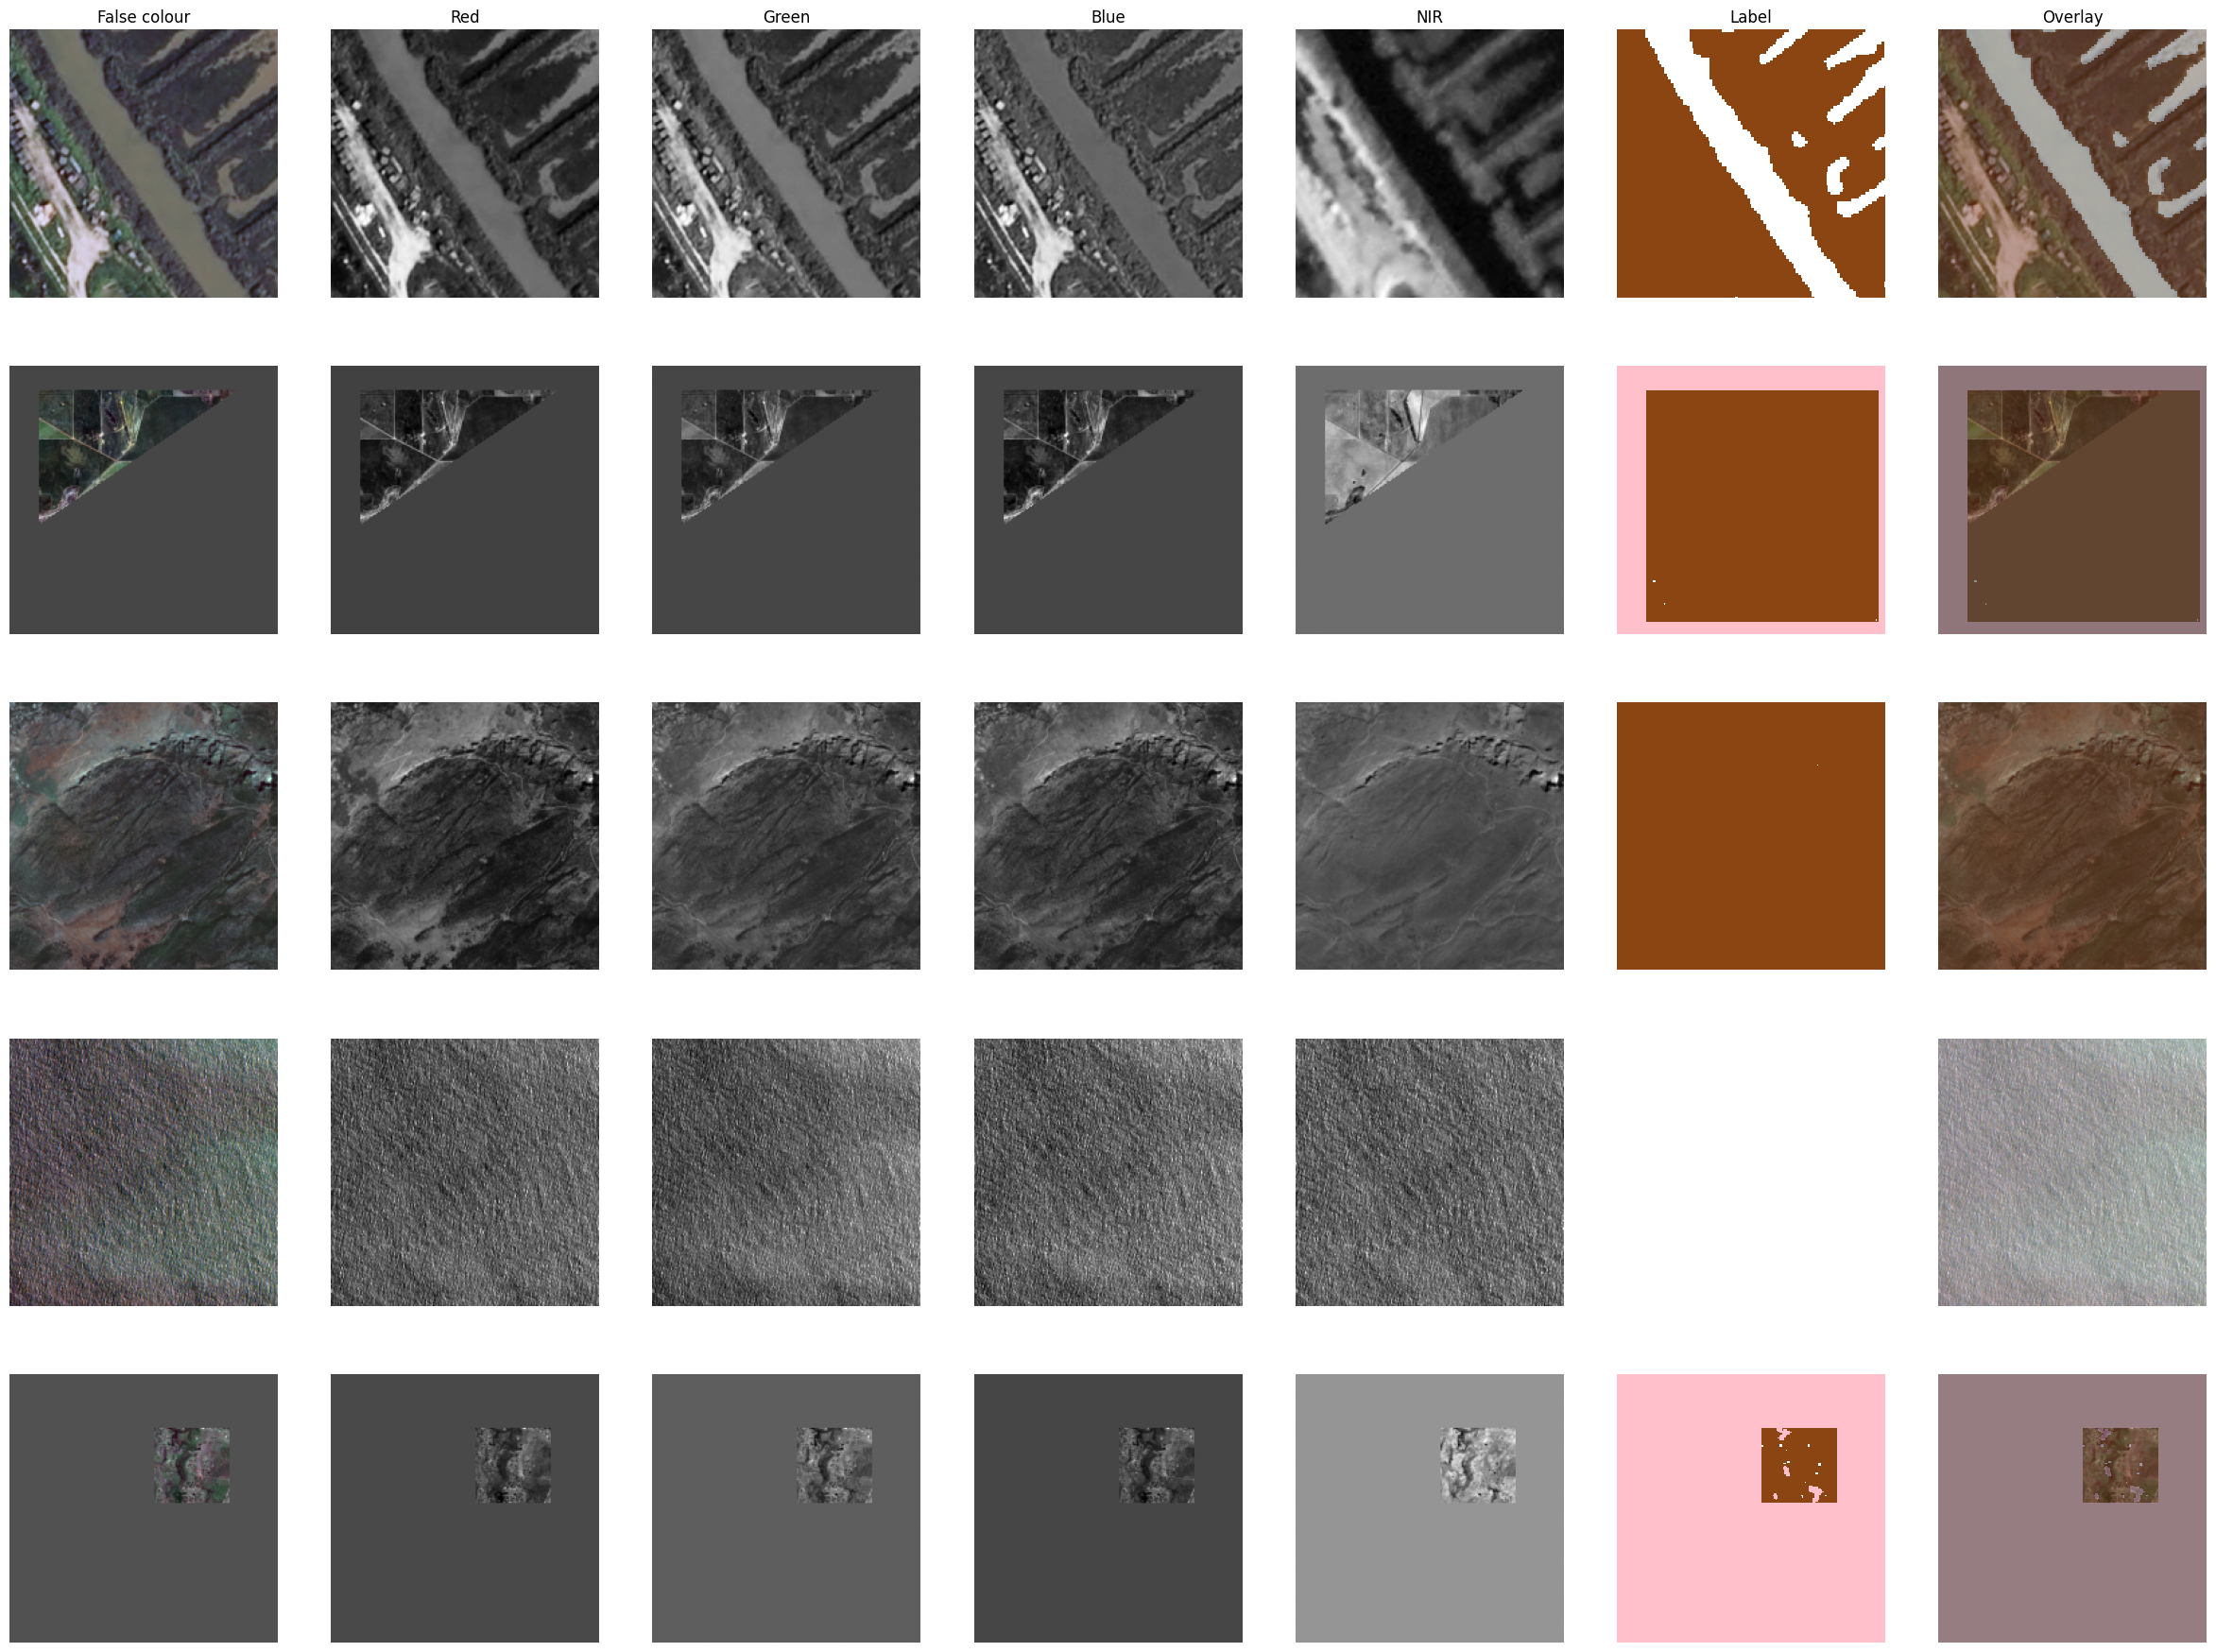

In [29]:
train_batch = dl.one_batch()
plot_batch(train_batch, labels=["False colour"] + band_labels, n=5)

In [30]:
train_batch[0][0][0].mean()

TensorImage(7.7438e-08, device='cuda:0')

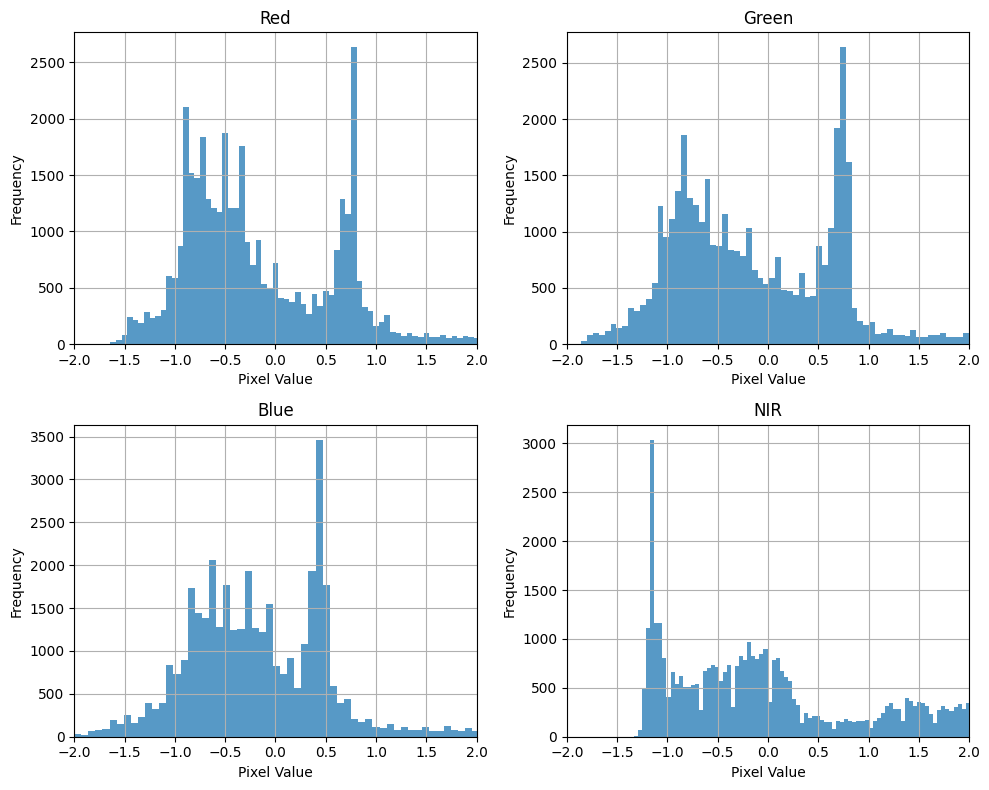

In [31]:
show_histo(train_batch, labels=band_labels)

In [32]:
train_batch[0].shape[1]

4

In [33]:
fai_model_name = f"PM_model_{model_full_name}_fai"
pytorch_model_name = f"PM_model_{model_full_name}_PT.pth"
pytorch_model_path = Path.cwd() / "models" / pytorch_model_name
state_path = pytorch_model_path.parent / f"{pytorch_model_path.stem}_state.pth"
safetensor_state_path = (
    pytorch_model_path.parent / f"{pytorch_model_path.stem}_state.safetensors"
)
config_path = pytorch_model_path.parent / f"{pytorch_model_path.stem}_config.json"
if pytorch_model_path.exists():
    raise ValueError("Model already exists", pytorch_model_name)
if state_path.exists():
    raise ValueError("State path already exists")
if safetensor_state_path.exists():
    raise ValueError("Safetensor state path already exists")
if config_path.exists():
    raise ValueError("Config path already exists")

print(f"Fastai model {fai_model_name}")
print(f"PyTorch model {pytorch_model_name}")
print(f"State path: {state_path}")
print(f"Safetensor state path: {safetensor_state_path}")


Fastai model PM_model_2.0.9_S1S2_L2A_flair_only_water_edgenext_x_small_fai
PyTorch model PM_model_2.0.9_S1S2_L2A_flair_only_water_edgenext_x_small_PT.pth
State path: /home/nick/Documents/Work code/OmniWaterMask-training/models/PM_model_2.0.9_S1S2_L2A_flair_only_water_edgenext_x_small_PT_state.pth
Safetensor state path: /home/nick/Documents/Work code/OmniWaterMask-training/models/PM_model_2.0.9_S1S2_L2A_flair_only_water_edgenext_x_small_PT_state.safetensors


In [34]:
if pytorch_model_path.exists():
    raise ValueError("Model already exists")

In [35]:
class_loss_weights_tensor = torch.tensor(class_loss_weights).float().cuda()
class_loss_weights_tensor

tensor([1., 2.], device='cuda:0')

In [36]:
cel = CrossEntropyLoss(
    reduction="none",
    weight=class_loss_weights_tensor,
    ignore_index=ignore_index,
)

dice_weight = 0.5


def masked_dice_loss(pred, target, smooth=1e-6):
    """Dice loss computed only on valid (non-ignored) pixels."""
    valid_mask = target != ignore_index

    pred_soft = F.softmax(pred, dim=1)

    # Compute dice on water class (class 1) for valid pixels only
    pred_water = pred_soft[:, 1][valid_mask]
    target_water = (target == 1)[valid_mask].float()

    intersection = (pred_water * target_water).sum()
    union = pred_water.sum() + target_water.sum()

    dice = (2.0 * intersection + smooth) / (union + smooth)
    return 1 - dice


def combo_loss(pred, target):
    # CE loss with distance weighting
    pixel_weight = distance_transform_torch(
        target, clip_distance=3, ignore_index=ignore_index
    )
    pixel_cel = cel(pred, target)
    ce_loss = (pixel_cel * pixel_weight).mean()

    # Dice loss on valid pixels only
    d_loss = masked_dice_loss(pred, target)

    return ce_loss + dice_weight * d_loss


In [37]:
metrics = [
    IgnoreIndexMetric(JaccardCoeff(axis=1), ignore_index=99),
]


In [38]:
callbacks = [
    SaveModelCallback(monitor="jaccard_coeff", fname=fai_model_name, with_opt=True),
    ShowGraphCallback(),
    GradientAccumulation(GA_batch_size),
]

In [39]:
if model_provider == "fastai":
    print(f"Using fastai model: {model_type}")
    timm_model = partial(
        timm.create_model,
        model_type,
        pretrained=True,
        in_chans=num_input_channels,
    )
    model = create_unet_model(
        img_size=(original_image_size, original_image_size),
        arch=timm_model,
        n_out=class_count,
        pretrained=True,
        act_cls=torch.nn.Mish,
    )
elif model_provider == "smp":
    print(f"Using segmentation_models_pytorch model: {model_type}")
    model = smp.Unet(
        encoder_name=f"tu-{model_type.split('.')[0]}",
        encoder_weights="imagenet",
        in_channels=num_input_channels,
        classes=class_count,
    )

else:
    raise ValueError(f"Unknown model provider: {model_provider}")


Using fastai model: edgenext_x_small.in1k


In [40]:
dummy_input = torch.randn(
    1, num_input_channels, original_image_size, original_image_size
)
model_output = model(dummy_input)
assert model_output.shape == (
    1,
    class_count,
    original_image_size,
    original_image_size,
), "Model output shape mismatch"


In [41]:
learner = Learner(
    dls=dl,
    model=model,
    loss_func=combo_loss,
    metrics=metrics,
    cbs=callbacks,
)


In [42]:
if bf16:
    print("Using BF16")
    learner = learner.to_bf16()

print(f"Using learning rate: {learning_rate}, with model {model_type}")

Using BF16
Using learning rate: 0.0001, with model edgenext_x_small.in1k


epoch,train_loss,valid_loss,jaccard_coeff,time
0,0.568240,0.564886,0.535167,03:12
1,0.213450,0.442124,0.699779,03:07
2,0.165110,0.222119,0.778324,03:11
3,0.152113,0.241473,0.878946,03:11
4,0.138532,0.185627,0.885702,03:13
5,0.132636,0.173869,0.879062,02:54
6,0.117862,0.215081,0.886008,02:56
7,0.118693,0.176773,0.771027,02:58
8,0.106630,0.197811,0.893105,02:56
9,0.115016,0.211627,0.885192,02:56


Better model found at epoch 0 with jaccard_coeff value: 0.5351672619750825.


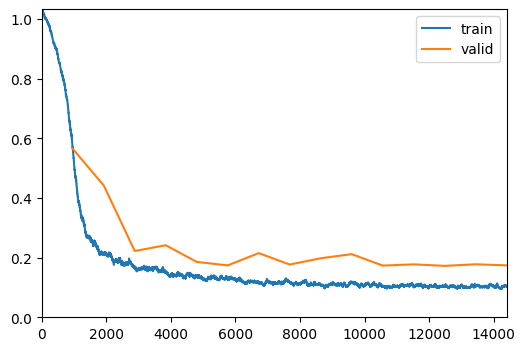

Better model found at epoch 1 with jaccard_coeff value: 0.6997792620729011.
Better model found at epoch 2 with jaccard_coeff value: 0.7783241691142937.
Better model found at epoch 3 with jaccard_coeff value: 0.8789460214942316.
Better model found at epoch 4 with jaccard_coeff value: 0.8857021140473417.
Better model found at epoch 6 with jaccard_coeff value: 0.8860081533913479.
Better model found at epoch 8 with jaccard_coeff value: 0.8931046152063564.
Better model found at epoch 10 with jaccard_coeff value: 0.8938889835253863.
Better model found at epoch 11 with jaccard_coeff value: 0.8949364857232281.
Better model found at epoch 13 with jaccard_coeff value: 0.8949919459134216.


In [43]:
learner.fit_one_cycle(
    n_epoch=epoch_count,
    lr_max=learning_rate,
)

In [44]:
# reload the model to get the best one
learner.load(fai_model_name)

In [45]:
# extract model from learner and move to cpu
model = learner.model.to("cpu")
model = model.float()

In [46]:
torch.save(model, pytorch_model_path)
pytorch_model_path

Path('/home/nick/Documents/Work code/OmniWaterMask-training/models/PM_model_2.0.9_S1S2_L2A_flair_only_water_edgenext_x_small_PT.pth')

In [47]:
torch.save(model.state_dict(), state_path)
state_path

Path('/home/nick/Documents/Work code/OmniWaterMask-training/models/PM_model_2.0.9_S1S2_L2A_flair_only_water_edgenext_x_small_PT_state.pth')

In [48]:
save_file(model.state_dict(), safetensor_state_path)
safetensor_state_path

Path('/home/nick/Documents/Work code/OmniWaterMask-training/models/PM_model_2.0.9_S1S2_L2A_flair_only_water_edgenext_x_small_PT_state.safetensors')